Import libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action='ignore')


Read in the data and visualize it

In [109]:
sales = pd.read_csv("TOTALSA.csv", parse_dates=['DATE'])\
        .rename(columns = {'TOTALSA': 'Sales'})

GDP = pd.read_csv("GDP.csv", parse_dates=['DATE'])\
        .assign(GDP = lambda cols: cols['GDP']/1000)


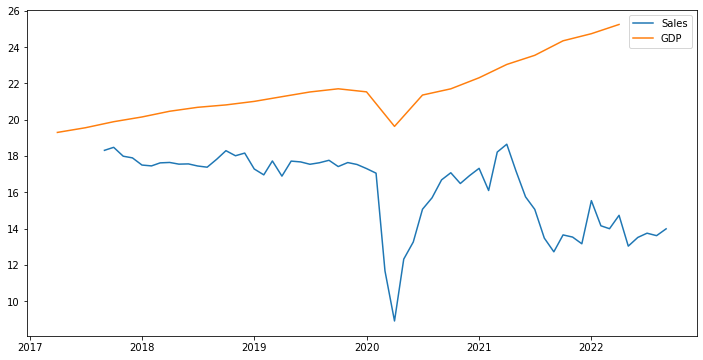

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(sales['DATE'], sales['Sales'], label='Sales')
plt.plot(GDP['DATE'], GDP['GDP'], label='GDP')
plt.legend()
plt.show()

Get sales and GDP on the same time grain and impute missing values

In [116]:
GDP = GDP.assign(DATE = lambda cols: cols['DATE'] + pd.Timedelta(32, 'D'))\
    .assign(DATE = lambda cols: cols['DATE'].apply(lambda x: x.replace(day=1)))

GDP

,DATE,GDP
0,2017-05-01,19.304506
1,2017-08-01,19.561896
2,2017-11-01,19.894750
3,2018-02-01,20.155486
4,2018-05-01,20.470197
5,2018-08-01,20.687278
6,2018-11-01,20.819269
7,2019-02-01,21.013085
8,2019-05-01,21.272448
9,2019-08-01,21.531839


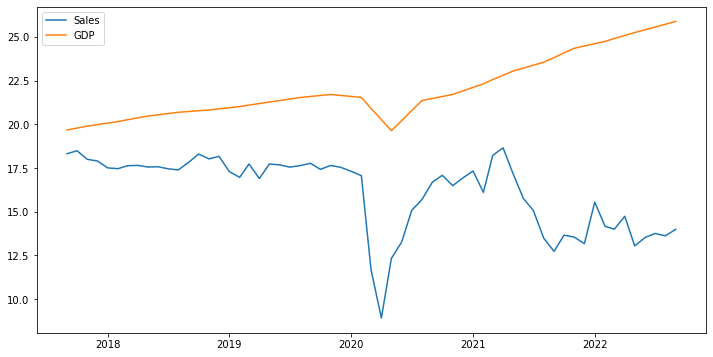

In [127]:
df = pd.merge(
    left = sales, 
    right = GDP, 
    on = 'DATE', 
    how = 'outer'
).sort_values(by = 'DATE', ascending=True)

df['GDP'] = df['GDP'].interpolate(method='linear', limit_direction='backward')

GDP_avg_growth_rate = (df['GDP'] / df['GDP'].shift(1)).dropna().tail(5).mean()
for i in range(df.shape[0]):
    if(pd.isnull(df.loc[i, 'GDP'])):
        df.loc[i, 'GDP'] = df.loc[i-1, 'GDP'] * GDP_avg_growth_rate

df = df.dropna(axis=0, how='any').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.legend()
plt.show()

Create training and test sets

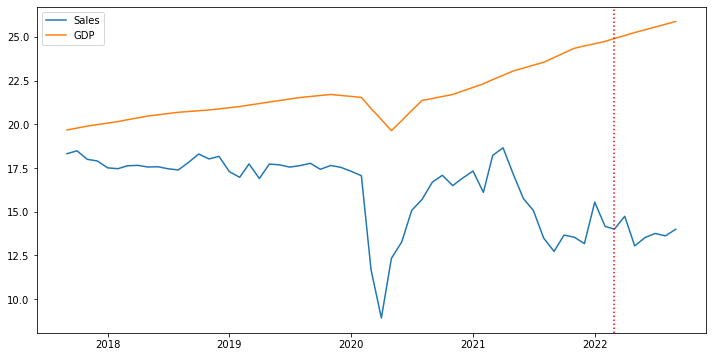

In [132]:
MAX_TRAINING_DATE = df.tail(7).iloc[0]['DATE']


plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['Sales'], label='Sales')
plt.plot(df['DATE'], df['GDP'], label='GDP')
plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')
plt.legend()
plt.show()

df_train = df.loc[df['DATE'] < MAX_TRAINING_DATE, :]
df_test = df.loc[df['DATE'] >= MAX_TRAINING_DATE, :]


Build an initial model

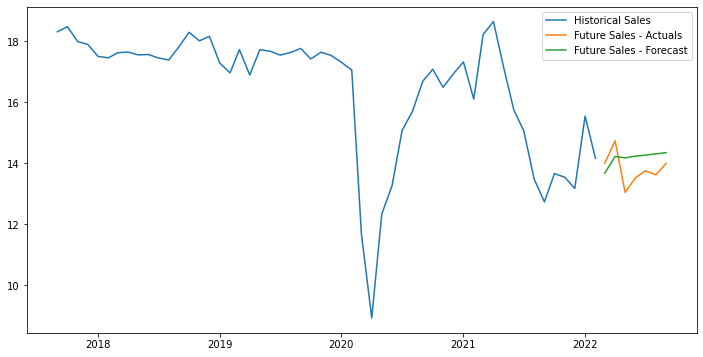

In [138]:
model = SARIMAX(
    endog = df_train['Sales'], 
    exog = df_train['GDP'], 
    order = (1, 1, 3), # p, d, q order parameters for arima
    trend = [1, 0], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (0,0,0, 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0], exog=df_test['GDP'])

plt.figure(figsize = (12, 6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actuals')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()


Create hyperparameter scoring function and parameter search step function

In [156]:
# Function to 'step' randomly in hyperparameter space
def step(params): 
    updated_params = deepcopy(params)
    selected_variable = np.random.choice(['p', 'd', 'q', 'P', 'D', 'Q', 'a0', 'a1'], size=1)[0]
    current_value = updated_params[selected_variable]

    # Update the current value randomly
    updated_value = current_value + np.random.choice([-1, 1], size=1)[0]

    # Enforce parameter limits
    if(selected_variable in ['p', 'q']):
        low, high = 0, 6
    else:
        low, high = 0, 1
    
    updated_value = min([max([low, updated_value]), high])

    updated_params[selected_variable] = updated_value

    return updated_params

# Function to score hyperparameter set
def score(params, data):
    
    error_scores = []

    for validation_steps in [1,2,3,4,5]:
        training_set_length = data.shape[0] - validation_steps

        model = SARIMAX(
            endog = data['Sales'].head(training_set_length), 
            exog = data['GDP'].head(training_set_length), 
            order = (params['p'], params['d'], params['q']), # p, d, q order parameters for arima
            trend = [params['a0'], params['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
            seasonal_order = (params['P'], params['D'], params['Q'], 12) # P, D, Q seasonal order parameters
        ).fit()

        forecast = model.forecast(steps=validation_steps, exog=data['GDP'].tail(validation_steps))
        actuals = data['Sales'].tail(validation_steps)
        
        # compute error metric and return
        error = (forecast.tail(1) - actuals.tail(1)).abs().mean()
        error_scores.append(error)

    return np.mean(error_scores)



Run hyperparameter optimization scan

In [163]:
# Initial guess
x0 = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 'a0': 1, 'a1': 1}
f0 = score(x0, df_train)

# Keep track of best parameters
xbest = deepcopy(x0)
fbest = f0

print('initial parameter score = ', f0)

initial parameter score =  1.6055875512994167


In [164]:
optimization_steps = 100

temperature = 0.05

optimization_progress = {'f0': [], 'fbest': []}

for t in range(optimization_steps):

    # Randomly changed x0
    x1 = step(x0)
    f1 = score(x1, df_train)

    # If the new point is lower in score than the previous (meaning better)
    if(f1 < f0):
        x0 = deepcopy(x1)
        f0 = f1
    else: # if new point is worse, accept with some probability
        if(np.random.random() < 2**(-(f1-f0)/temperature)):
            x0 = deepcopy(x1)
            f0 = f1

    # Update the 'best' parameters
    if(f0 < fbest):
        fbest = f0
        xbest = deepcopy(x0)

    # Print out progress
    print('current score = {}, best score = {}'.format(f0, fbest))
    optimization_progress['f0'].append(f0)
    optimization_progress['fbest'].append(fbest)


current score = 1.6055875512994167, best score = 1.6055875512994167
current score = 1.6055875512994167, best score = 1.6055875512994167
current score = 1.6055875512994167, best score = 1.6055875512994167
current score = 1.6055875512994167, best score = 1.6055875512994167
current score = 1.6055875512994167, best score = 1.6055875512994167
current score = 1.615781769699264, best score = 1.6055875512994167
current score = 1.615781769699264, best score = 1.6055875512994167
current score = 1.615781769699264, best score = 1.6055875512994167
current score = 1.615781769699264, best score = 1.6055875512994167
current score = 1.4572098986116733, best score = 1.4572098986116733
current score = 1.4572098986116733, best score = 1.4572098986116733
current score = 1.4572098986116733, best score = 1.4572098986116733
current score = 1.4572098986116733, best score = 1.4572098986116733
current score = 1.4572098986116733, best score = 1.4572098986116733
current score = 1.4572098986116733, best score = 1.4

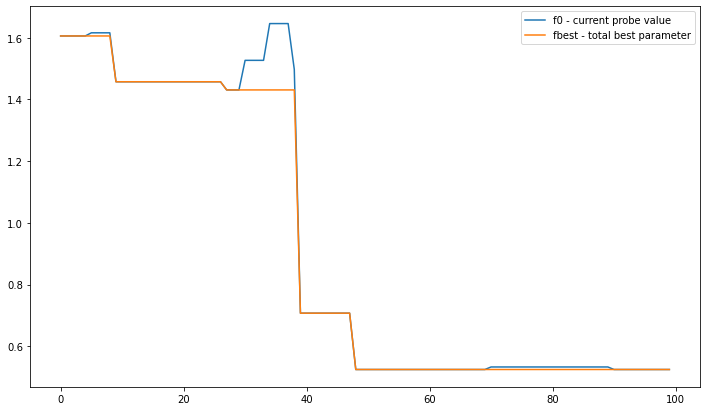

In [166]:
plt.figure(figsize = (12, 7))
plt.plot(optimization_progress['f0'], label = 'f0 - current probe value')
plt.plot(optimization_progress['fbest'], label = 'fbest - total best parameter')
plt.legend()
plt.show()

Select the best hyperparameters, refit to whole training set, and predict test set

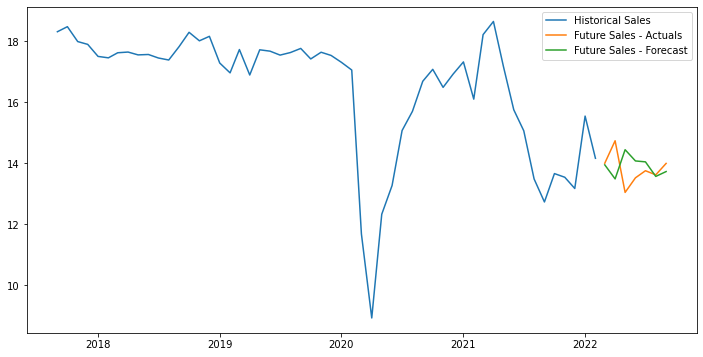

In [167]:
model = SARIMAX(
    endog = df_train['Sales'], 
    exog = df_train['GDP'], 
    order = (xbest['p'], xbest['d'], xbest['q']), # p, d, q order parameters for arima
    trend = [xbest['a0'], xbest['a1']], # A(t) = a0 + a1*t + a2*t^2 ... 
    seasonal_order = (xbest['P'], xbest['D'], xbest['Q'], 12) # P, D, Q seasonal order parameters
).fit()

forecast = model.forecast(steps=df_test.shape[0], exog=df_test['GDP'])

plt.figure(figsize = (12, 6))
plt.plot(df_train['DATE'], df_train['Sales'], label='Historical Sales')
plt.plot(df_test['DATE'], df_test['Sales'], label='Future Sales - Actuals')
plt.plot(df_test['DATE'], forecast, label='Future Sales - Forecast')
plt.legend()
plt.show()